In [61]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm

In [62]:
# Data directories (use absolute paths)
train_dir = r'D:\Comys_Hackathon5\dataset\Task_A\train'
val_dir = r'D:\Comys_Hackathon5\dataset\Task_A\val'

# Image transformations
image_size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomRotation(10),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

batch_size = 32
num_workers = 2

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print('Classes:', train_dataset.classes)

Classes: ['female', 'male']


In [63]:
print('Train batches:', len(train_loader))
print('Val batches:', len(val_loader))

Train batches: 61
Val batches: 14


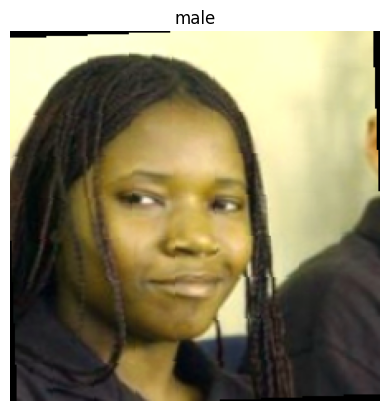

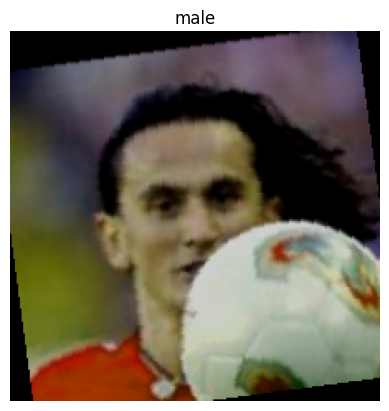

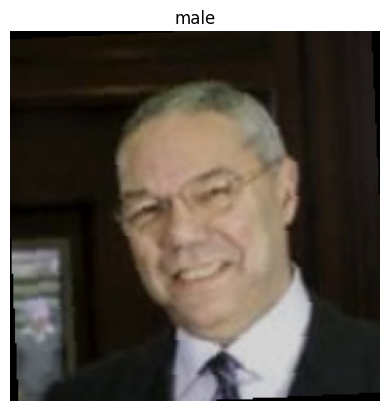

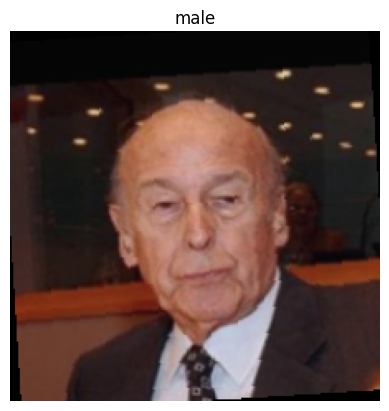

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and show an image
def imshow(img, label):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Show the first 4 images in the batch
for i in range(4):
    imshow(inputs[i], train_dataset.classes[classes[i]])

In [65]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights
# Load a pretrained ResNet18 model
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
num_ftrs = model.classifier[1].in_features

# Replace the final fully connected layer for 2 classes
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.7),  
    nn.Linear(num_ftrs, 2)
)

# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [66]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final classification layer
for param in model.classifier[1].parameters():
    param.requires_grad = True

In [67]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3, weight_decay=1e-2)

In [68]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/25, Loss: 0.4037, Accuracy: 0.8432
Epoch 2/25, Loss: 0.3014, Accuracy: 0.8801
Epoch 3/25, Loss: 0.2647, Accuracy: 0.9019
Epoch 4/25, Loss: 0.2545, Accuracy: 0.8982
Epoch 5/25, Loss: 0.2578, Accuracy: 0.8910
Epoch 6/25, Loss: 0.2747, Accuracy: 0.8915
Epoch 7/25, Loss: 0.2473, Accuracy: 0.8993
Epoch 8/25, Loss: 0.2475, Accuracy: 0.9019
Epoch 9/25, Loss: 0.2508, Accuracy: 0.9045
Epoch 10/25, Loss: 0.2539, Accuracy: 0.9045
Epoch 11/25, Loss: 0.2519, Accuracy: 0.9045
Epoch 12/25, Loss: 0.2499, Accuracy: 0.9039
Epoch 13/25, Loss: 0.2513, Accuracy: 0.9024
Epoch 14/25, Loss: 0.2310, Accuracy: 0.9091
Epoch 15/25, Loss: 0.2431, Accuracy: 0.9029
Epoch 16/25, Loss: 0.2572, Accuracy: 0.9013
Epoch 17/25, Loss: 0.2311, Accuracy: 0.9086
Epoch 18/25, Loss: 0.2467, Accuracy: 0.9013
Epoch 19/25, Loss: 0.2471, Accuracy: 0.9013
Epoch 20/25, Loss: 0.2421, Accuracy: 0.9107
Epoch 21/25, Loss: 0.2505, Accuracy: 0.9003
Epoch 22/25, Loss: 0.2351, Accuracy: 0.9055
Epoch 23/25, Loss: 0.2303, Accuracy: 0.90

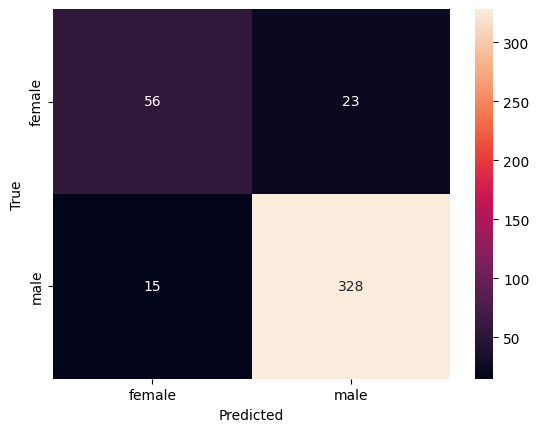

              precision    recall  f1-score   support

      female       0.79      0.71      0.75        79
        male       0.93      0.96      0.95       343

    accuracy                           0.91       422
   macro avg       0.86      0.83      0.85       422
weighted avg       0.91      0.91      0.91       422



In [72]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

In [74]:
   torch.save(model.state_dict(), 'efficientnet_gender_classifier.pth')